Name: Qiaochu Dai

Githubname: Levi519519

USCID: 7326115044

### 1. Decision Trees as Interpretable Models
##### (a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

 a1	Temperature of patient  { 35C-42C }	
 a2	Occurrence of nausea  { yes, no }	
 a3	Lumbar pain  { yes, no }	
 a4	Urine pushing (continuous need for urination)  { yes, no }	
 a5	Micturition pains  { yes, no }	
 a6	Burning of urethra, itch, swelling of urethra outlet  { yes, no }	
 d1	decision: Inflammation of urinary bladder  { yes, no }	
 d2	decision: Nephritis of renal pelvis origin { yes, no }	

In [190]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import datasets
from sklearn import metrics
import os
from itertools import cycle
import warnings
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_multilabel_classification
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [71]:
path='../data/diagnosis_data.csv'
df=pd.read_csv(path, sep='\s+', encoding='UTF_16', header=None, decimal=',')
df.columns=['Temp','nausea','Lumbar_pain','urination','micturition_pain','burning','Inflammation','Nephritis']
for i in range(0,len(df)):
    for j in range(1,8):
        if df.iloc[i,j]=='no':
            df.iloc[i,j]='0'
        else:
            df.iloc[i,j]='1'
df

Temp nausea Lumbar_pain urination micturition_pain burning Inflammation  \
0    35.5      0           1         0                0       0            0   
1    35.9      0           0         1                1       1            1   
2    35.9      0           1         0                0       0            0   
3    36.0      0           0         1                1       1            1   
4    36.0      0           1         0                0       0            0   
..    ...    ...         ...       ...              ...     ...          ...   
115  41.4      0           1         1                0       1            0   
116  41.5      0           0         0                0       0            0   
117  41.5      1           1         0                1       0            0   
118  41.5      0           1         1                0       1            0   
119  41.5      0           1         1                0       1            0   

    Nephritis  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
115         1  
116         0  
117         1  
118         1  
119         1  

[120 rows x 8 columns]

##### (b) Build a decision tree on the whole data set and plot it.1

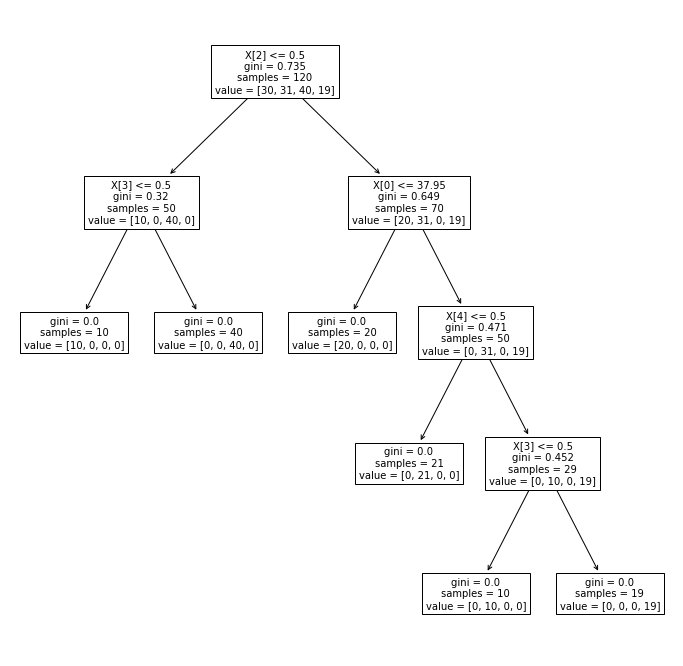

|--- feature_2 <= 0.50
|   |--- feature_3 <= 0.50
|   |   |--- class: 0
|   |--- feature_3 >  0.50
|   |   |--- class: 2
|--- feature_2 >  0.50
|   |--- feature_0 <= 37.95
|   |   |--- class: 0
|   |--- feature_0 >  37.95
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_4 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 3



In [73]:
# use label powerset approach
from sklearn import tree
from IPython.display import Image
X=df.iloc[:,0:6]
y=df.iloc[:,6:]
y_class=[]
for i in range(0,len(y)):
    if y.iloc[i,0]=='0' and y.iloc[i,1]=='0':
        y_class.append('0')
    if y.iloc[i,0]=='0' and y.iloc[i,1]=='1':
        y_class.append('1')
    if y.iloc[i,0]=='1' and y.iloc[i,1]=='0':
        y_class.append('2')
    if y.iloc[i,0]=='1' and y.iloc[i,1]=='1':
        y_class.append('3')
        
clf = DecisionTreeClassifier(random_state=50)
clf.fit(X, y_class)
plt.figure(figsize=(12,12))
tree.plot_tree(clf, fontsize=10)
plt.show()

text = tree.export_text(clf)
print(text)

##### (c) Convert the decision rules into a set of IF-THEN rules.

In [74]:
def tree_to_pseudo(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [75]:
tree_to_pseudo(clf, ['Temp','nausea','Lumbar_pain','urination','micturition_pain','burning'])

 if ( Lumbar_pain <= 0.5 ) {
   if ( urination <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0.  0. 40.  0.]]
   }
 } else {
   if ( Temp <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( micturition_pain <= 0.5 ) {
       return [[ 0. 21.  0.  0.]]
     } else {
       if ( urination <= 0.5 ) {
         return [[ 0. 10.  0.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


##### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [85]:
pruning_path = clf.cost_complexity_pruning_path(X, y_class)

ccp_alphas, impurities = pruning_path.ccp_alphas, pruning_path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y_class)
    clfs.append(clf)

# Choose the best pruned tree based on cross-validation
scores = [cross_val_score(clf, X, y_class, cv=5).mean() for clf in clfs]
best_tree_index = np.argmax(scores)
best_pruned_tree = clfs[best_tree_index]

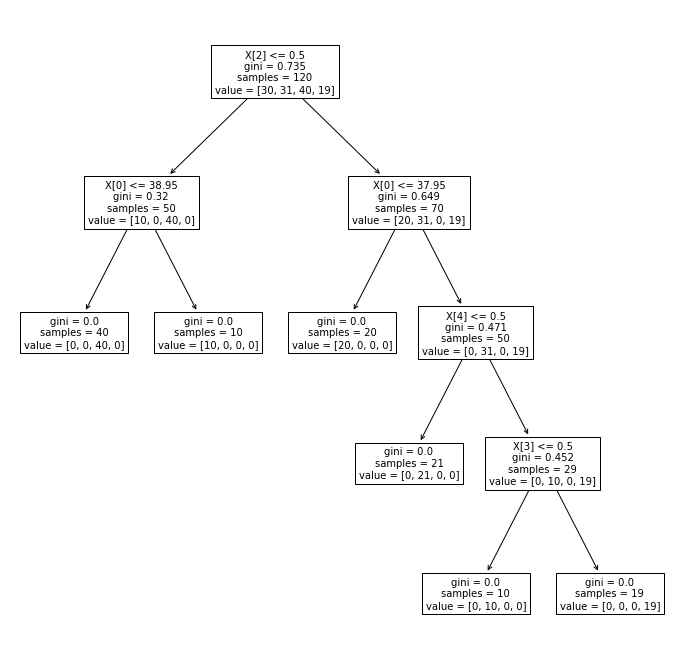

|--- feature_2 <= 0.50
|   |--- feature_0 <= 38.95
|   |   |--- class: 2
|   |--- feature_0 >  38.95
|   |   |--- class: 0
|--- feature_2 >  0.50
|   |--- feature_0 <= 37.95
|   |   |--- class: 0
|   |--- feature_0 >  37.95
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_4 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 3



In [81]:
best_pruned_tree.fit(X, y_class)
plt.figure(figsize=(12,12))
tree.plot_tree(best_pruned_tree, fontsize=10)
plt.show()

text = tree.export_text(best_pruned_tree)
print(text)

In [82]:
tree_to_pseudo(best_pruned_tree, ['Temp','nausea','Lumbar_pain','urination','micturition_pain','burning'])

 if ( Lumbar_pain <= 0.5 ) {
   if ( Temp <= 38.95000076293945 ) {
     return [[ 0.  0. 40.  0.]]
   } else {
     return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temp <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( micturition_pain <= 0.5 ) {
       return [[ 0. 21.  0.  0.]]
     } else {
       if ( urination <= 0.5 ) {
         return [[ 0. 10.  0.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


### 2. The LASSO and Boosting for Regression

##### (a) Download the Communities and Crime data3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [89]:
path_data='../data/communities_data.csv'
path_columns='../data/communities_names.txt'
df=pd.read_csv(path2, header=None, na_values='?')
column_name=[]
file=open(path_columns)
for line in file:
    if "@attribute" in line:
        line=line.split(" ")
        column_name.append(line[1])
df.columns=column_name
df

state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1989     12     NaN        NaN    TempleTerracecity    10        0.01   
1990      6     NaN        NaN          Seasidecity    10        0.05   
1991      9     9.0    80070.0        Waterburytown    10        0.16   
1992     25    17.0    72600.0          Walthamcity    10        0.08   
1993      6     NaN        NaN          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[1994 rows x 128 columns]

In [115]:
train_df=df.iloc[:1495,:]
test_df=df.iloc[1495:, :]
train_df

state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1490      6     NaN        NaN     Hillsboroughtown     8        0.00   
1491      6     NaN        NaN           Orangecity     8        0.16   
1492     13     NaN        NaN         Waycrosscity     8        0.01   
1493     39    85.0    49056.0           Mentorcity     8        0.06   
1494     34    17.0    79610.0      WestNewYorktown     8        0.05   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1490           0.59          0.01          0.69          1.00  ...      0.02   
1491           0.62          0.03          0.74          0.48  ...      0.07   
1492           0.36          0.95          0.24          0.03  ...      0.03   
1493           0.53          0.01          0.98          0.05  ...      0.08   
1494           0.43          0.08          0.65          0.12  ...      0.00   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1490     0.14            0.22        NaN            NaN                  NaN   
1491     0.40            0.14       0.07           0.05                 0.85   
1492     0.12            0.01        NaN            NaN                  NaN   
1493     0.15            0.02        NaN            NaN                  NaN   
1494     1.00            1.00       0.00           0.01                 0.77   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1490                  NaN                 0.00              NaN   
1491                  0.5                 0.61             0.19   
1492                  NaN                 0.00              NaN   
1493                  NaN                 0.00              NaN   
1494                  0.0                 0.51             0.18   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494                 0.23  

[1495 rows x 128 columns]

##### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [135]:
def imputation(data):
    columns_with_nan = data.columns[data.isna().any()].tolist()
    for col in columns_with_nan:
        impute_value=data[col][data[col].notna()].sum()/len(data[col].notna())
        for i in range(0,len(data)):
            if data[col].isna()[i]:
                data[col][i]=impute_value
    return data

In [136]:
train=train_df.iloc[:,5:]
test=test_df.iloc[:,5:]
test.reset_index(drop=True, inplace=True)
train=imputation(train)
test=imputation(test)

In [137]:
train

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1490         0.07         0.41         0.28         0.23        0.57  ...   
1491         0.42         0.44         0.57         0.40        0.25  ...   
1492         0.01         0.44         0.42         0.27        0.63  ...   
1493         0.01         0.40         0.40         0.24        0.29  ...   
1494         1.00         0.37         0.52         0.33        0.44  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20   0.060000        0.04000   
1         0.02     0.12            0.45   0.026214        0.01287   
2         0.01     0.21            0.02   0.026214        0.01287   
3         0.02     0.39            0.28   0.026214        0.01287   
4         0.04     0.09            0.02   0.026214        0.01287   
...        ...      ...             ...        ...            ...   
1490      0.02     0.14            0.22   0.026214        0.01287   
1491      0.07     0.40            0.14   0.070000        0.05000   
1492      0.03     0.12            0.01   0.026214        0.01287   
1493      0.08     0.15            0.02   0.026214        0.01287   
1494      0.00     1.00            1.00   0.000000        0.01000   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                0.900000             0.500000                 0.32   
1                0.113993             0.072241                 0.00   
2                0.113993             0.072241                 0.00   
3                0.113993             0.072241                 0.00   
4                0.113993             0.072241                 0.00   
...                   ...                  ...                  ...   
1490             0.113993             0.072241                 0.00   
1491             0.850000             0.500000                 0.61   
1492             0.113993             0.072241                 0.00   
1493             0.113993             0.072241                 0.00   
1494             0.770000             0.000000                 0.51   

      PolicBudgPerPop  ViolentCrimesPerPop  
0            0.140000                 0.20  
1            0.030495                 0.67  
2            0.030495                 0.43  
3            0.030495                 0.12  
4            0.030495                 0.03  
...               ...                  ...  
1490         0.030495                 0.03  
1491         0.190000                 0.20  
1492         0.030495                 0.30  
1493         0.030495   

##### (c) Plot a correlation matrix for the features in the data set.

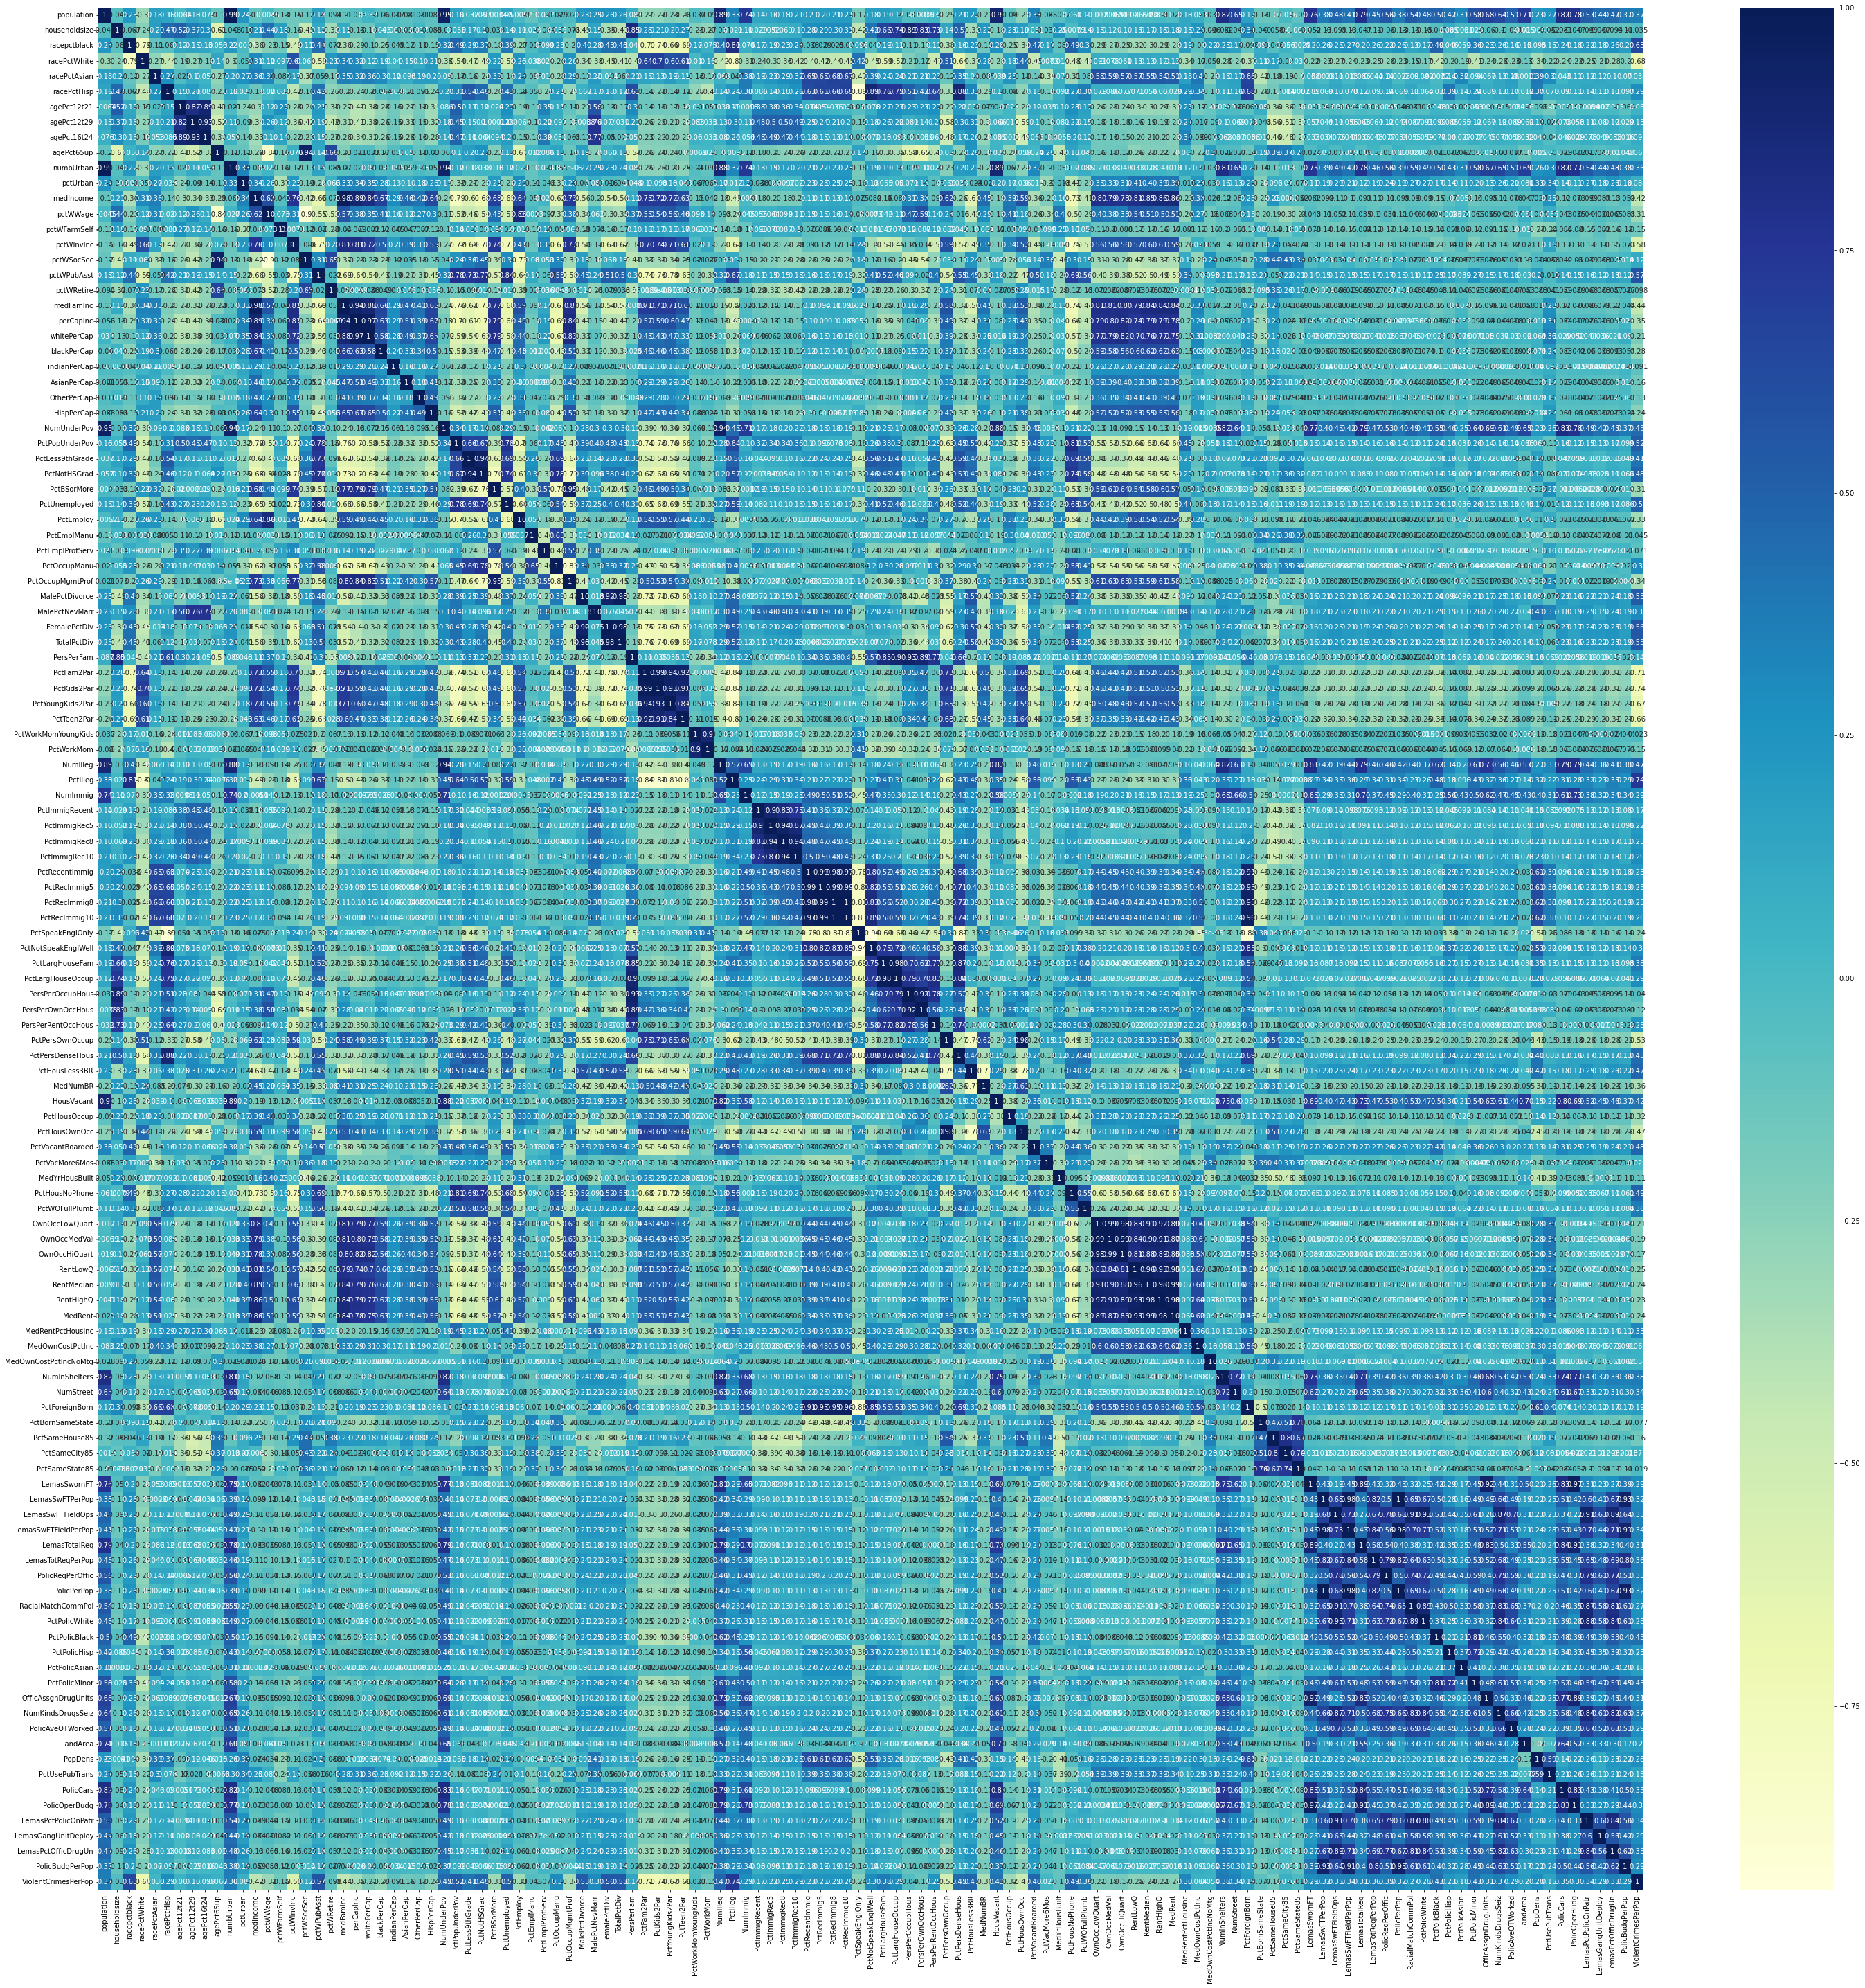

In [151]:
plt.figure(figsize=(50, 50))
df_new=pd.concat([train_df, test_df], axis=0, ignore_index=True)
df_new=df_new.iloc[:,5:]
df_new=imputation(df_new)
corr = df_new.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

##### (d) Calculate the Coefficient of Variation CV for each feature, where CV = ms , in which s is sample standard deviation and m is sample mean.

In [152]:
describe = df_new.describe(include='all')
for col in df_new.columns:
    std = describe.loc['std']
    mean = describe.loc['mean']
    describe.loc['CV'] = std / mean
describe.loc[['std','mean','CV']]

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
std     0.126906       0.163717      0.253442      0.244039      0.208877   
mean    0.057593       0.463395      0.179629      0.753716      0.153681   
CV      2.203503       0.353298      1.410920      0.323782      1.359162   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
std      0.232492     0.155196     0.143564     0.166505    0.179185  ...   
mean     0.144022     0.424218     0.493867     0.336264    0.423164  ...   
CV       1.614278     0.365840     0.290693     0.495161    0.423442  ...   

      LandArea   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
std   0.109459  0.203092        0.229055   0.099420       0.060785   
mean  0.065231  0.232854        0.161685   0.048012       0.022580   
CV    1.678031  0.872187        1.416673   2.070723       2.691955   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
std              0.231527             0.211378             0.240328   
mean             0.205641             0.129650             0.094052   
CV               1.125880             1.630369             2.555266   

      PolicBudgPerPop  ViolentCrimesPerPop  
std          0.089105             0.232985  
mean         0.057424             0.237979  
CV           1.551686             0.979015  

[3 rows x 123 columns]

##### (e). Pick √128⌋features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [153]:
CV=describe.loc[['std','mean','CV']].T
n=int(np.sqrt(128))
sorted_CV = CV.sort_values(by='CV',ascending=False)
sorted_CV.iloc[:n,2]

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasSwornFT           2.889192
PctPolicAsian          2.882580
PolicOperBudg          2.691955
LemasPctOfficDrugUn    2.555266
LemasTotalReq          2.474433
OfficAssgnDrugUnits    2.398432
NumUnderPov            2.304970
Name: CV, dtype: float64

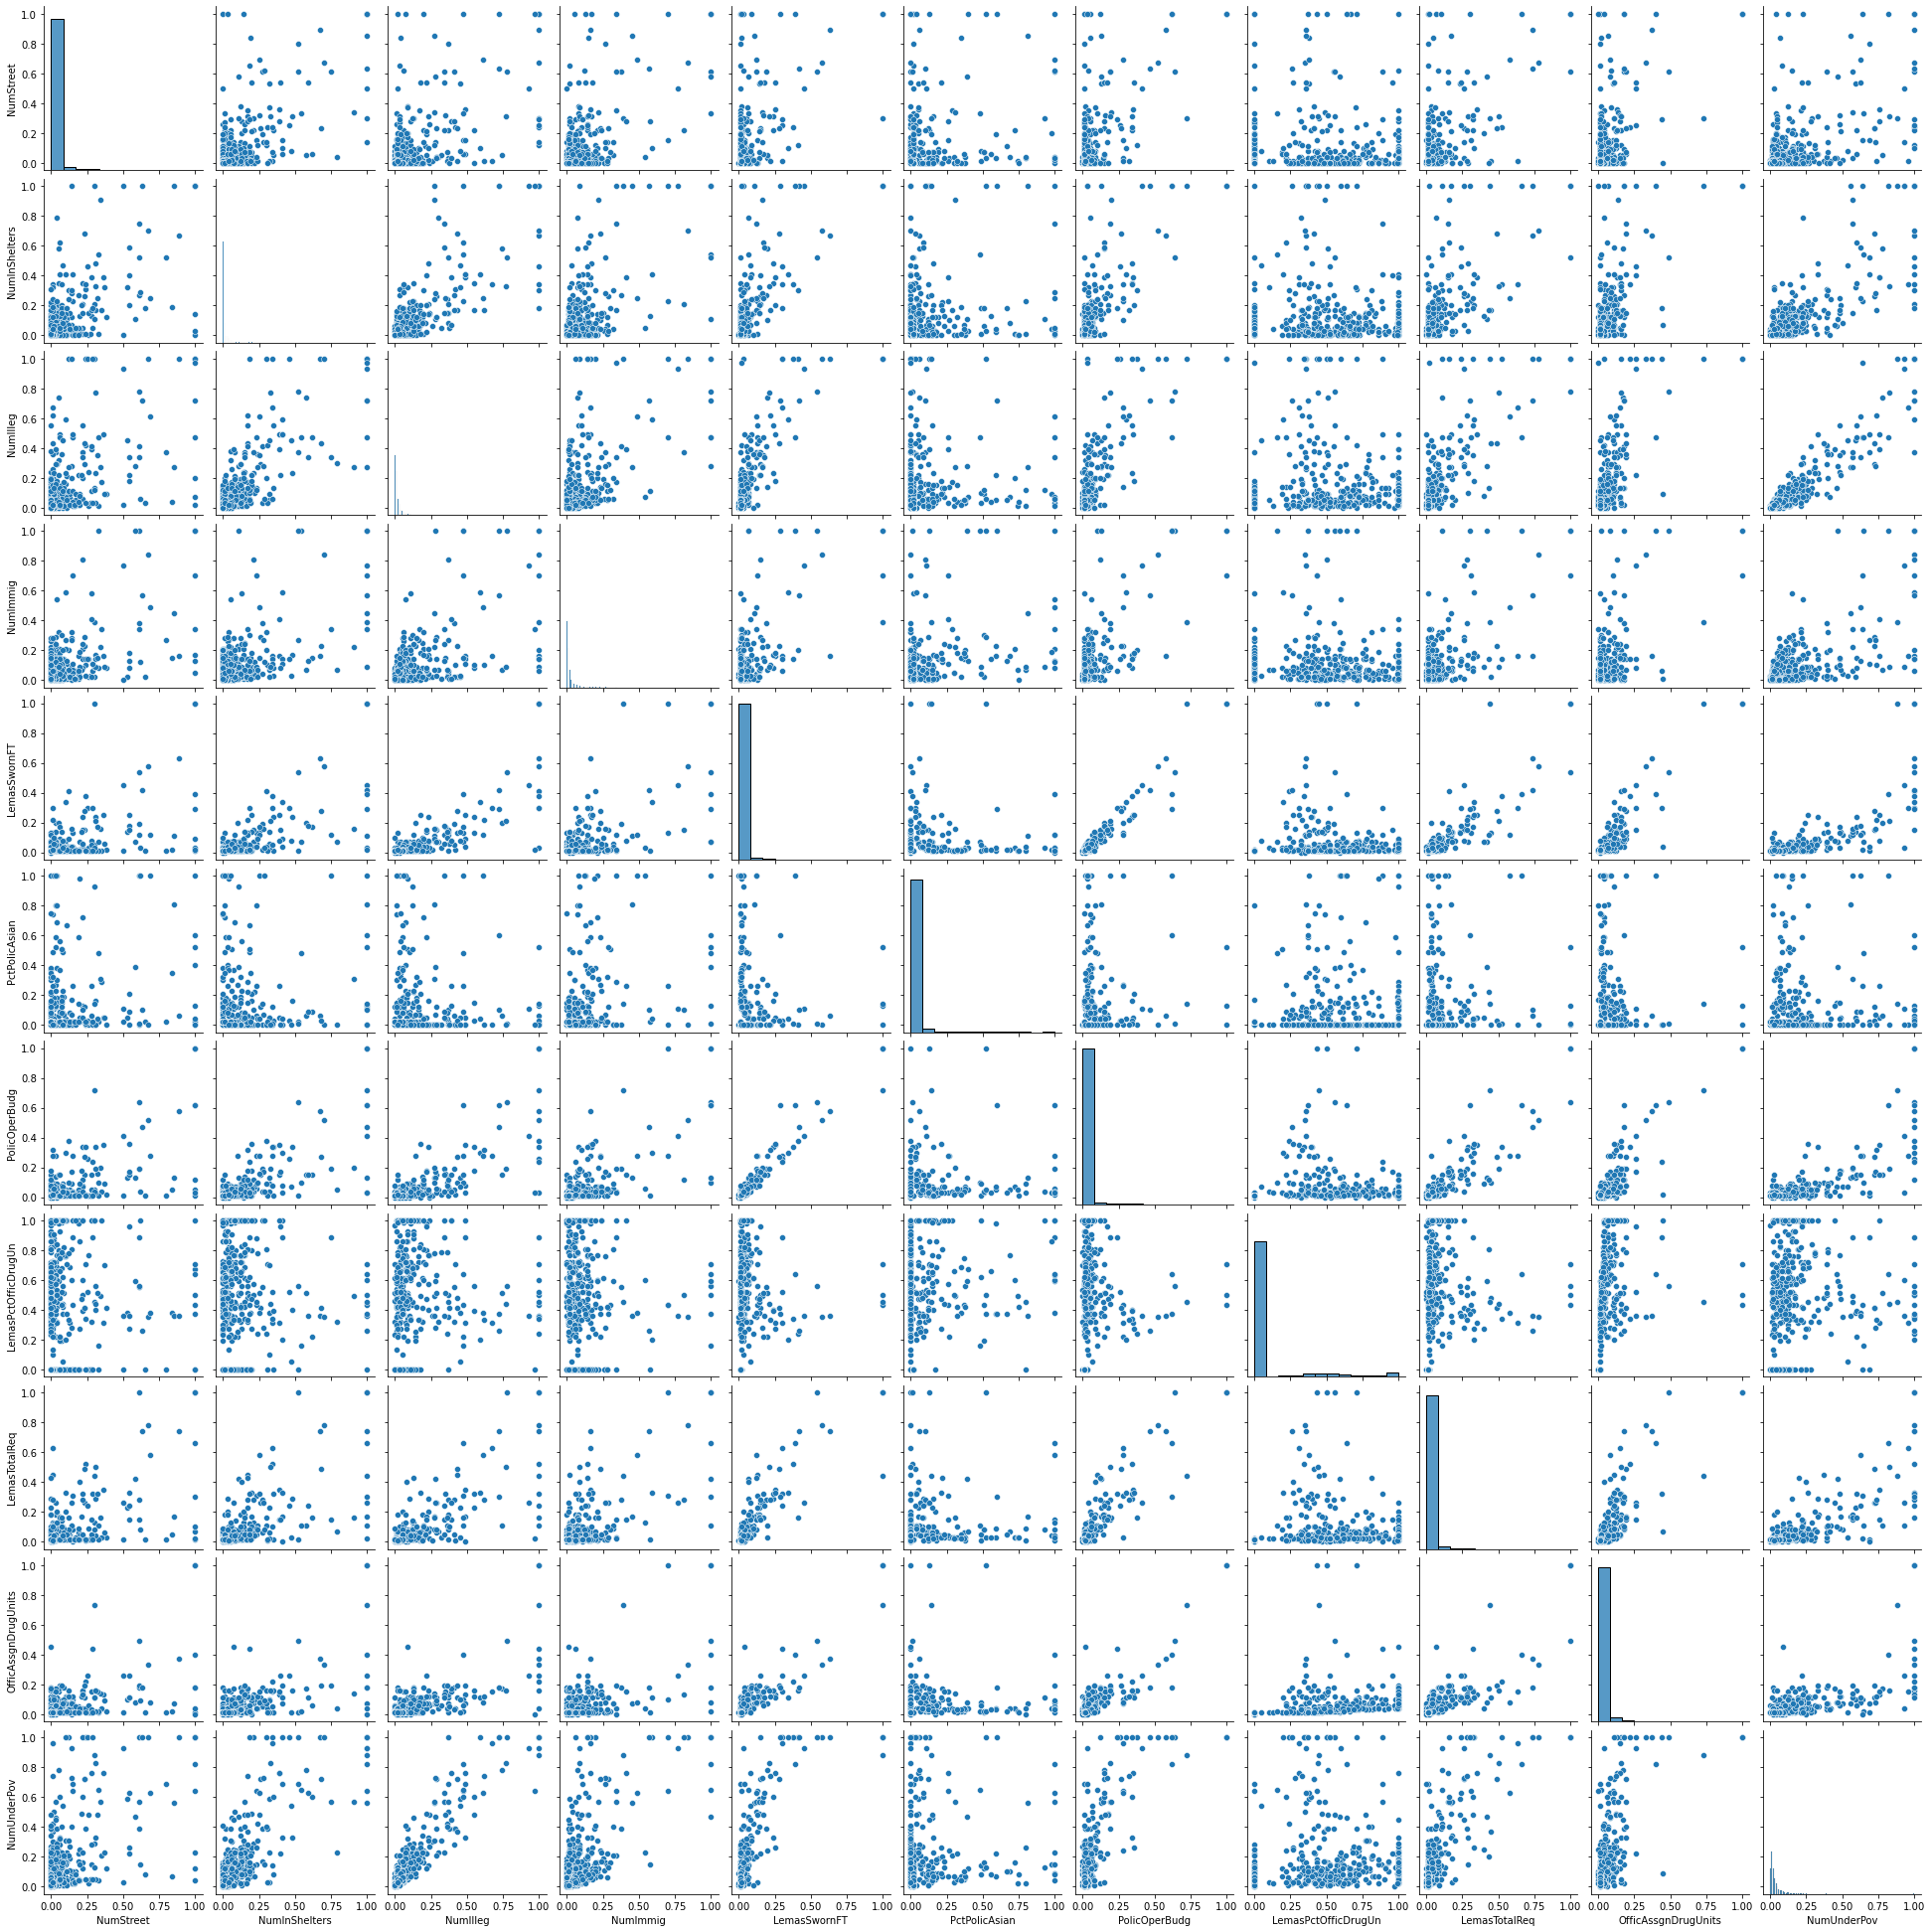

In [160]:
sns.pairplot(df_new[sorted_CV.iloc[:n,2].index])
plt.show()

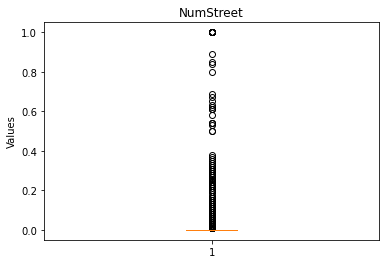

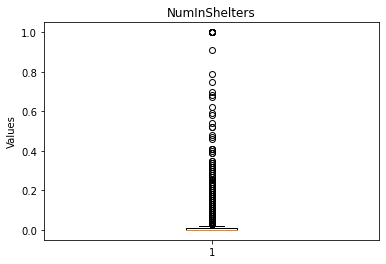

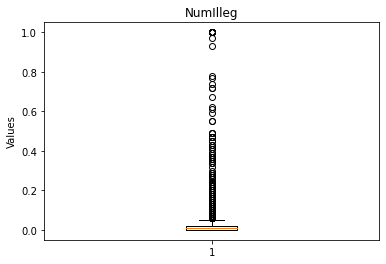

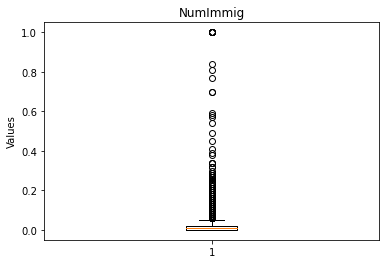

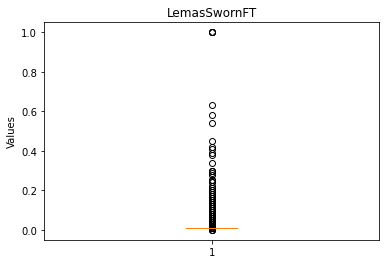

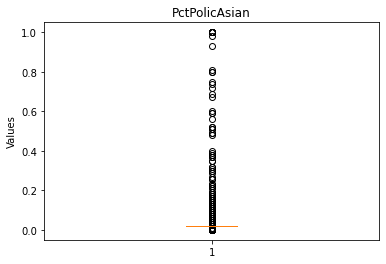

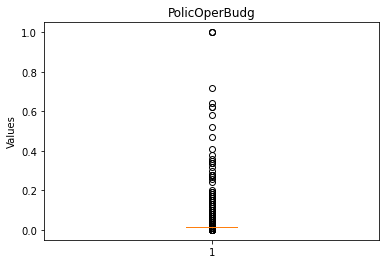

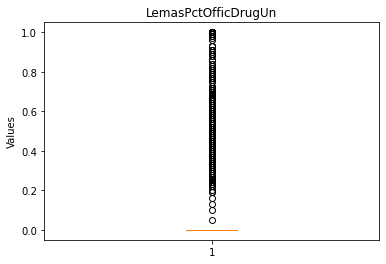

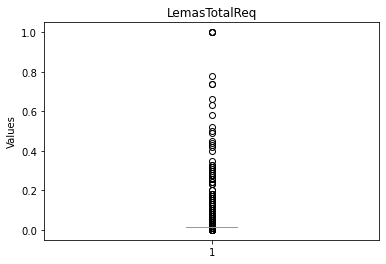

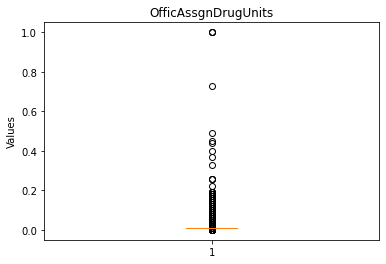

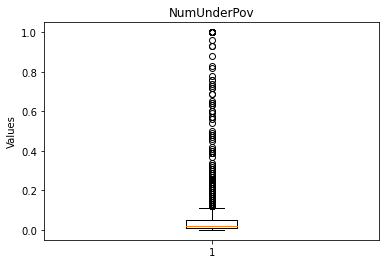

In [166]:
for col in sorted_CV.T.columns[:n]:
    plt.boxplot(df_new[col])
    plt.title(col)
    plt.ylabel('Values')
    plt.show()

##### (f) Fit a linear model using least squares to the training set and report the test error.

In [193]:
X_train=train.iloc[:,:-1]
y_train=train['ViolentCrimesPerPop']
X_test=test.iloc[:,:-1]
y_test=test['ViolentCrimesPerPop']
X_train_cons=sm.add_constant(X_train)
X_test_cons=sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_cons).fit()
pred_y = model.predict(X_test_cons)
display(model.summary())

mean_squared_error(y_test, pred_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.712
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     28.03
Date:                 Wed, 25 Oct 2023   Prob (F-statistic):          1.30e-291
Time:                         22:46:20   Log-Likelihood:                 957.23
No. Observations:                 1495   AIC:                            -1670.
Df Residuals:                     1373   BIC:                            -1023.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4290      0.250      1.712      0.087      -0.062       0.920
population                0.0226      0.476      0.048      0.962      -0.912       0.957
householdsize            -0.0190      0.098     -0.195      0.845      -0.210       0.172
racepctblack              0.2788      0.060      4.656      0.000       0.161       0.396
racePctWhite              0.0037      0.067      0.056      0.955      -0.127       0.134
racePctAsian             -0.0292      0.041     -0.706      0.480      -0.111       0.052
racePctHisp               0.0110      0.065      0.168      0.866      -0.117       0.139
agePct12t21               0.1752      0.129      1.358      0.175      -0.078       0.428
agePct12t29              -0.3446      0.185     -1.859      0.063      -0.708       0.019
agePct16t24              -0.1200      0.197     -0.608      0.543      -0.507       0.267
agePct65up                0.0558      0.124      0.451      0.652      -0.187       0.299
numbUrban                -0.1827      0.465     -0.393      0.695      -1.095       0.730
pctUrban                  0.0500      0.019      2.667      0.008       0.013       0.087
medIncome                -0.1713      0.202     -0.848      0.397      -0.568       0.225
pctWWage                 -0.1376      0.107     -1.289      0.198      -0.347       0.072
pctWFarmSelf              0.0455      0.023      1.942      0.052      -0.000       0.091
pctWInvInc               -0.2083      0.081     -2.571      0.010      -0.367      -0.049
pctWSocSec                0.1376      0.125      1.100      0.271      -0.108       0.383
pctWPubAsst               0.0614      0.054      1.136      0.256      -0.045       0.167
pctWRetire               -0.1239      0.044     -2.784      0.005      -0.211      -0.037
medFamInc                 0.3056      0.188      1.623      0.105      -0.064       0.675
perCapInc                -0.0444      0.221     -0.200      0.841      -0.479       0.390
whitePerCap              -0.1970      0.179     -1.100      0.272      -0.548       0.154
blackPerCap              -0.0397      0.029     -1.345      0.179      -0.098       0.018
indianPerCap             -0.0433      0.023     -1.903      0.057      -0.088       0.001
AsianPerCap               0.0299      0.022      1.373      0.170      -0.013       0.073
OtherPerCap               0.0310      0.022      1.393      0.164      -0.013       0.075
HispPerCap                0.0325      0.029      1.135      0.257      -0.024       0.089
NumUnderPov               0.0882      0.192      0.460      0.646      -0.288       0.465
PctPopUnderPov           -0.2102      0.074     -2.826      0.005      -0.356      -0.064
PctLess9thGrade          -0.0516      0.079     -0.656      0.512      -0.206       0.103
PctNotHSGrad

0.018015144313785827

MSE=0.018

##### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [194]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
optimal_alpha = grid_search.best_params_['alpha']

ridge = Ridge(alpha=optimal_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print('optimal alpha = '+str(optimal_alpha))
print('test error = '+str(test_mse))

optimal alpha = 1
test error = 0.017599648527761094


##### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized4 features. Report the test error for both cases and compare them.

In [175]:
def Lasso_model(X_train,y_train,X_test,y_test,standardized=False):
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    lasso = Lasso(max_iter=10000)
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    if standardized:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
    grid_search.fit(X_train, y_train)
    optimal_alpha = grid_search.best_params_['alpha']

    lasso = Lasso(alpha=optimal_alpha, max_iter=10000)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred)

    selected_variables = [feature for i, feature in enumerate(X.columns) if lasso.coef_[i] != 0]
    print('test_error = '+str(test_error))
    print('selected_variables: ')
    print(selected_variables)

In [195]:
Lasso_model(X_train,y_train,X_test,y_test,standardized=False)

test_error = 0.017481875126405266
selected_variables: 
['Lumbar_pain', 'urination']


In [196]:
Lasso_model(X_train,y_train,X_test,y_test,standardized=True)

test_error = 0.01767329129438469
selected_variables: 
['Temp', 'Lumbar_pain']


The test error of standardized features is higher than that of original features. 

##### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [197]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
mse_scores = []
for m in range(1, len(X_train.columns)):
    model = LinearRegression()
    scores = -cross_val_score(model, X_train_pca[:, :m], y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(scores.mean())
best_m = np.argmin(mse_scores)+1
model.fit(X_train_pca[:, :best_m], y_train)

X_test_pca = pca.transform(X_test)
y_pred = model.predict(X_test_pca[:, :best_m])

test_error = mean_squared_error(y_test, y_pred)
print('best M: '+str(best_m))
test_error

best M: 96


0.018387414783140626

##### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [205]:
param_grid = {'alpha': [0.001,0.005,0.1,0.5,1,5,10,50]}
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state = 50
)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print('best_alpha: '+str(best_alpha))

best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state = 50,
    alpha=best_alpha
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print('test MSE:'+str(mse))

best_alpha: 0.001
test MSE:0.02027978451028179
